In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import time
import re
import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import TensorDataset, DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1111)
random.seed(1111)

device

device(type='cuda')

# **Utils**

In [2]:
def generate_sequences(seq_length, num_samples):
    X = np.random.randint(0, 10, size=(num_samples, seq_length))
    Y = np.zeros_like(X)
    Y[:, 0] = X[:, 0]
    Y[:, 1:] = (X[:, 1:] + X[:, 0:1]) % 10
    return X, Y


class SequenceDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
        self.Y = torch.tensor(Y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type="RNN"):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.model_type = model_type
        if model_type == "RNN":
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size, device):
        if self.model_type == "LSTM":
            return (torch.zeros(1, batch_size, self.hidden_size, device=device),
                    torch.zeros(1, batch_size, self.hidden_size, device=device))
        return torch.zeros(1, batch_size, self.hidden_size, device=device)
    

def train_model(model, train_loader, criterion, optimizer, num_epochs, device, model_name="model"):
    model.train()
    losses = []
    best_loss = float('inf')
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, 10), targets.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), f"{model_name}.pth")
            np.save(f"{model_name}_losses.npy", np.array(losses))
        
        clear_output(wait=True)
        print(f'Time {time.time() - start_time:.2f} sec, Epoch {epoch+1}/{num_epochs}, Loss: {losses[-1]:.4f}')
    
    return losses, model


def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, -1)
            total += targets.size(0) * targets.size(1)
            correct += (predicted == targets).sum().item()
    return correct / total


def test_model(model_type, model_path, test_loader, device, hidden_size=64):
    model = RNNModel(input_size=1, hidden_size=hidden_size, output_size=10, model_type=model_type).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    accuracy = evaluate_model(model, test_loader, device)
    print(f"{model_type} Test Accuracy: {accuracy:.4f}")
    
    with torch.no_grad():
        sample_inputs, sample_targets = next(iter(test_loader))
        sample_inputs = sample_inputs[:1].to(device)
        sample_targets = sample_targets[:1].to(device)
        outputs = model(sample_inputs)
        _, predicted = torch.max(outputs, -1)
        print(f"\nSample Input: {sample_inputs.squeeze().cpu().numpy()}")
        print(f"Predicted Output: {predicted.squeeze().cpu().numpy()}")
        print(f"True Output: {sample_targets.squeeze().cpu().numpy()}")
    
    return accuracy


def main(models, train_loader, test_loader, **params):
    criterion = nn.CrossEntropyLoss()
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        losses, model = train_model(model, train_loader, criterion, optimizer, params['num_epochs'], device, model_name=name)
        accuracy = evaluate_model(model, test_loader, device)
        results[name] = {"losses": losses, "accuracy": accuracy}
        print(f"{name} Test Accuracy: {accuracy:.4f}")
    
    plt.figure(figsize=(10, 6))
    for name, result in results.items():
        plt.plot(result["losses"], label=f"{name} Loss")
    plt.title("Training Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# **Creation parameters**

In [3]:
params = {
    "seq_length": 10,
    "num_samples": 10000,
    "test_samples": 1000,
    "hidden_size": 64,
    "num_epochs": 15,
    "batch_size": 32,
    "learning_rate": .001,
}

# **Creation datasets**

In [4]:
X, Y = generate_sequences(params["seq_length"], params["num_samples"])
X_test, Y_test = generate_sequences(params["seq_length"], params["test_samples"])

In [5]:
train_dataset = SequenceDataset(X, Y)
test_dataset = SequenceDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"])

# **Creation models**

In [6]:
models = {
    "RNN": RNNModel(input_size=1, hidden_size=params["hidden_size"], output_size=10, model_type="RNN").to(device),
    "LSTM": RNNModel(input_size=1, hidden_size=params["hidden_size"], output_size=10, model_type="LSTM").to(device),
    "GRU": RNNModel(input_size=1, hidden_size=params["hidden_size"], output_size=10, model_type="GRU").to(device)
}

# **Train models**

Time 6.28 sec, Epoch 15/15, Loss: 0.0760
GRU Test Accuracy: 0.9997


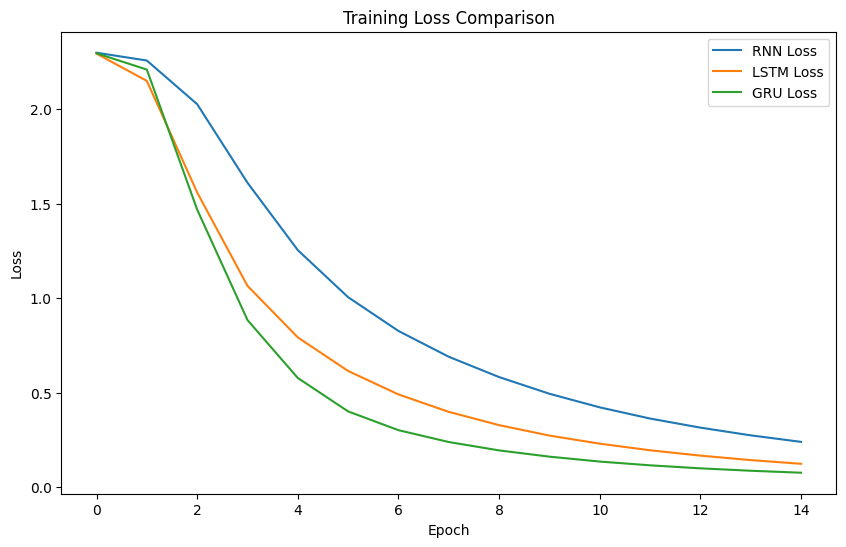

In [7]:
main(models, train_loader, test_loader, **params)

# **Testing models**

In [8]:
model_configs = {
    "RNN": "RNN.pth",
    "LSTM": "LSTM.pth",
    "GRU": "GRU.pth"
}

for model_type, model_path in model_configs.items():
    print(f"\nTesting {model_type}...")
    test_model(model_type, model_path, test_loader, device, params["hidden_size"])


Testing RNN...
RNN Test Accuracy: 0.9912

Sample Input: [7. 9. 7. 2. 2. 1. 7. 0. 2. 2.]
Predicted Output: [7 6 4 9 9 8 4 7 9 9]
True Output: [7 6 4 9 9 8 4 7 9 9]

Testing LSTM...
LSTM Test Accuracy: 0.9991

Sample Input: [7. 9. 7. 2. 2. 1. 7. 0. 2. 2.]
Predicted Output: [7 6 4 9 9 8 4 7 9 9]
True Output: [7 6 4 9 9 8 4 7 9 9]

Testing GRU...
GRU Test Accuracy: 0.9997

Sample Input: [7. 9. 7. 2. 2. 1. 7. 0. 2. 2.]
Predicted Output: [7 6 4 9 9 8 4 7 9 9]
True Output: [7 6 4 9 9 8 4 7 9 9]


# **Task 2: nietzsche.txt with LSTM**

In [9]:
with open('nietzsche.txt', encoding='utf-8') as f:
    text = f.read().lower()
print('length:', len(text))
text = re.sub('[^a-z ]', ' ', text)
text = re.sub(r'\s+', ' ', text)

length: 600893


In [10]:
text[:50]

'preface supposing that truth is a woman what then '

In [11]:
INDEX_TO_CHAR = sorted(list(set(text)))
CHAR_TO_INDEX = {c: i for i, c in enumerate(INDEX_TO_CHAR)}

CHAR_TO_INDEX

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [12]:
MAX_LEN = 40
STEP = 3
SENTENCES = []
NEXT_CHARS = []
for i in range(0, len(text) - MAX_LEN, STEP):
    SENTENCES.append(text[i: i + MAX_LEN])
    NEXT_CHARS.append(text[i + MAX_LEN])
print('Num sents:', len(SENTENCES))

Num sents: 193075


In [13]:
SENTENCES[:10]

['preface supposing that truth is a woman ',
 'face supposing that truth is a woman wha',
 'e supposing that truth is a woman what t',
 'upposing that truth is a woman what then',
 'osing that truth is a woman what then is',
 'ng that truth is a woman what then is th',
 'that truth is a woman what then is there',
 't truth is a woman what then is there no',
 'ruth is a woman what then is there not g',
 'h is a woman what then is there not grou']

In [14]:
NEXT_CHARS[:10]

['w', 't', 'h', ' ', ' ', 'e', ' ', 't', 'r', 'n']

In [15]:
print('Vectorization...')
X = torch.zeros((len(SENTENCES), MAX_LEN), dtype=int)
Y = torch.zeros((len(SENTENCES)), dtype=int)
for i, sentence in enumerate(SENTENCES):
    for t, char in enumerate(sentence):
        X[i, t] = CHAR_TO_INDEX[char]
    Y[i] = CHAR_TO_INDEX[NEXT_CHARS[i]]

Vectorization...


In [16]:
X[0:1], Y[0]

(tensor([[16, 18,  5,  6,  1,  3,  5,  0, 19, 21, 16, 16, 15, 19,  9, 14,  7,  0,
          20,  8,  1, 20,  0, 20, 18, 21, 20,  8,  0,  9, 19,  0,  1,  0, 23, 15,
          13,  1, 14,  0]]),
 tensor(23))

In [17]:
BATCH_SIZE=512
dataset = torch.utils.data.TensorDataset(X, Y)
data = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True)

In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self, rnnClass, dictionary_size, embedding_size, num_hiddens, num_classes):
        super().__init__()
        
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(dictionary_size, embedding_size)
        self.hidden = rnnClass(embedding_size, num_hiddens, batch_first=True)
        self.output = nn.Linear(num_hiddens, num_classes)
        
    def forward(self, X):
        out = self.embedding(X)
        out, (hidden_state, _) = self.hidden(out)
        predictions = self.output(hidden_state[-1])
        return predictions

In [19]:
model = NeuralNetwork(nn.LSTM, len(CHAR_TO_INDEX), 64, 128, len(CHAR_TO_INDEX))

In [20]:
model(X[0:1])

tensor([[ 0.1330, -0.0277,  0.1203, -0.1097,  0.0996,  0.0657,  0.0331, -0.0684,
          0.0117,  0.0137,  0.0021, -0.0963, -0.2104, -0.0564,  0.0565, -0.0765,
          0.0686, -0.0027,  0.1553,  0.0902, -0.1050, -0.1091, -0.0713,  0.1320,
         -0.0563, -0.0622,  0.0227]], grad_fn=<AddmmBackward0>)

In [21]:
model = model.cuda()

In [22]:
def sample(preds):
    softmaxed = torch.softmax(preds, 0)
    probas = torch.distributions.multinomial.Multinomial(1, softmaxed).sample()
    return probas.argmax()

def generate_text():
    start_index = random.randint(0, len(text) - MAX_LEN - 1)

    generated = ''
    sentence = text[start_index: start_index + MAX_LEN]
    generated += sentence

    for i in range(MAX_LEN):
        x_pred = torch.zeros((1, MAX_LEN), dtype=int)
        for t, char in enumerate(generated[-MAX_LEN:]):
            x_pred[0, t] = CHAR_TO_INDEX[char]

        preds = model(x_pred.cuda())[0].cpu()
        next_char = INDEX_TO_CHAR[sample(preds)]
        generated = generated + next_char

    print(generated[:MAX_LEN] + '|' + generated[MAX_LEN:])

In [23]:
generate_text()

s conscience will look down upon with sc|wpusgs hedzijdcpedylpfiftzvmlrxgmocsid y


In [24]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [27]:
for ep in range(100):
    start = time.time()
    train_loss = 0.
    train_passed = 0

    model.train()
    for X_b, y_b in tqdm.tqdm(data):
        X_b, y_b = X_b.cuda(), y_b.cuda()
        optimizer.zero_grad()
        answers = model.forward(X_b)
        loss = criterion(answers, y_b)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        train_passed += 1

    clear_output(wait=True)

    print("Epoch {}. Time: {:.3f}, Train loss: {:.3f}".format(ep, time.time() - start, train_loss / train_passed))
    model.eval()
    generate_text()

Epoch 99. Time: 2.931, Train loss: 0.930
and displays the noble soul has no aptit|ude that according to him of magic mind 


In [34]:
model.eval()
generate_text()

 more plainly of instinct and reason the| commonst man kazait pristic corssed do 


In [45]:
start_idx = text.index('instinct and reason')
text[start_idx: start_idx + 50]

'instinct and reason the question whether in respec'